<h1>2. fáza - predspracovanie dát</h1>

In [350]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import Imputer
from sklearn import linear_model

import re

percentil5 = []
percentil95 = []

imp = Imputer(missing_values='NaN', strategy='median')

linearKurtOx = linear_model.LinearRegression()
linearMeanGlu = linear_model.LinearRegression()

In [351]:
def splitPersonalInfo(dataO):
    temp = dataO['personal_info'].str.split("\r\r\n|--|\\|", expand = True)
    dataO['ethn'] = temp[0]
    dataO['state'] = temp[1]
    dataO['edu'] = temp[2]
    dataO['status'] = temp[3]
    dataO['fam_memb'] = temp[4] 
    dataO.drop(['personal_info'], axis = 1, inplace = True)

In [352]:
def fusionDuplicates(datasetO):
    duplicat = datasetO[datasetO['name'].duplicated(keep=False)]
    duplicat = duplicat.sort_values('name')
    duplicat = duplicat.reset_index(drop=True)
    
    for i, row in duplicat.iterrows():
        if(i%2==1):
            duplicat = duplicat.drop(i)
            continue
        for j, value in row.items():
            dupValue = duplicat.loc[i+1,j]
            if(pd.isna(value)):
                duplicat.loc[i,j]=dupValue
    datasetO.drop_duplicates(subset='name',keep=False,inplace=True)
    result = datasetO.append(duplicat, ignore_index=True)
    return(result)

In [353]:
def correctValuesO(dataset):
    for col in dataset.columns:
        if(dataset[col].dtype != np.object):
            continue
        dataset[col] = dataset[col].str.replace('_','-')
        dataset[col] = dataset[col].replace(to_replace = r'.*\?.*', value = np.nan, regex = True)
        dataset[col] = dataset[col].replace(to_replace = r'^[Nn][Aa][Nn]$', value = np.nan, regex = True)
        if(col=='pregnant'):
            dataset[col] = dataset[col].replace(['T','F'], ['t', 'f'])
            dataset[col] = dataset[col].replace(to_replace = r'[Tt][Rr][Uu][Ee]', value = 't', regex = True)
            dataset[col] = dataset[col].replace(to_replace = r'[Ff][Aa][Ll][Ss][Ee]', value = 'f', regex = True)

def correctDates(series):
    s = series.str.split("-", expand = True)
    x = 0
    while(x<len(series)):
#        print(str(x)+" "+s.iloc[x])
        if(re.match(r'^[0-9][0-9]-[0-9][0-9]-[0-9][0-9]$', series.loc[x])):
            if(s.iloc[x][0][:1]=='0'):
                series.loc[x] = "20"+s.iloc[x][0]+"-"+s.iloc[x][1]+"-"+s.iloc[x][2][0:2]
            else:
                series.loc[x] = "19"+s.iloc[x][0]+"-"+s.iloc[x][1]+"-"+s.iloc[x][2][0:2]
#            x += 1
#            continue
         #if(len(s.iloc[x][2])>2):
         #   series.loc[x] = s.iloc[x][0]+"-"+s.iloc[x][1]+"-"+s.iloc[x][2][:2]
        if(re.match(r'^[0-9][0-9]-[0-9][0-9]-[0-9][0-9][0-9][0-9]$', series.loc[x])):
            y = s.iloc[x][0]
            s.iloc[x][0] = s.iloc[x][2]
            s.iloc[x][2] = y
            series.loc[x] = s.iloc[x][0]+"-"+s.iloc[x][1]+"-"+s.iloc[x][2][0:2]
        if(len(series.loc[x])>10):
            series.loc[x] = series.loc[x][0:10]
        x += 1
        
def correctValuesP(dataset):
    for col in dataset.columns:
        if(dataset[col].dtype != np.object):
            continue
        dataset[col] = dataset[col].str.replace('/','-')    
    correctDates(dataset["date_of_birth"])
        

In [354]:
def fusionDatasets(dataset1, dataset2):
    newDS = dataset1.merge(dataset2, on='name')
    newDS = newDS.drop(columns=['name', 'address_x', 'address_y'])
    return newDS

In [355]:
def correctAge(dataF):
    x = 0
    for x in range(len(dataF)):
        #print(x)
        s = dataF['date_of_birth'].iloc[x].split('-', 2)
        year = s[0]
        #116 najstarsi clovek v sucastnosti
        if(dataF['age'].iloc[x]>116):
            age = dataF['age'].iloc[x]/100
            if((2019-int(age) == int(year) or (2019-int(age) == int(year)+1))):
                dataF['age'].iloc[x] =  int(age);
                continue
            else:
                print("ERROR  "+str(age)+"  "+str(int(year)))
        elif(dataF['age'].iloc[x]<-116):
            age = dataF['age'].iloc[x]/(-100)
            if(2019-int(age) == int(year) or 2019-int(age) == int(year)+1):
                dataF['age'].iloc[x] =  int(age);
                continue
            else:
                print("ERROR  "+str(age)+"  "+str(int(year)))
        else:
            age = 2019 - int(year)
            if(age<=0):
                dataF['age'].iloc[x] = np.nan
            else:
                dataF['age'].iloc[x] =  int(age);
            

In [357]:
def detectReplaceOutliers(dataF):
    for col in dataF.columns:
        if(dataF[col].dtype == np.object):
            continue
        if(col == 'capital-loss' or col == 'capital-gain' or col == 'age'):
            continue
        if(col != 'std_glucose' and col != 'fnlwgt' and col != 'mean_glucose' and col != 'hours-per-week'):
            dataF.loc[:,col] = dataF[col].apply(lambda x: -2.5 if x<-2.5 else x)
            dataF.loc[:,col] = pd.Series(np.log(dataF[col]+2.5))
        percentil5.append(dataF[col].quantile(0.05))
        percentil95.append(dataF[col].quantile(0.95))
        p5 = percentil5[-1]
        p95 = percentil95[-1]
        print(col+" q0.05: "+str(p5))
        print(col+" q0.95: "+str(p95))
        dataF.loc[:,col] = dataF[col].apply(lambda x: p5 if x<p5 else x)
        dataF.loc[:,col] = dataF[col].apply(lambda x: p95 if x>p95 else x)

Z predchádzajúcej analýzy sme zistili, že stlpce std_glucose, fnlwgt, mean_glucose, hours-per-week majú približne normalné rozdelenie a ostatné stľpce bude potrebné transformovať pomocou logaritmu. Ten nemôže byť zo záporného čísla, preto použijeme minimálnu hodnotu z analýzi (-1.976976) a k dátam bude pre istotu prirítané 2,5. Zároveň aj ošetríme aby ani v testovacých dátach nebola nižšia hodnota tak, že všetky nižšie prestavíme na túto hodnotu. 

In [358]:
def transformDetectReplaceOutliers(dataF):
    i = 0
    for col in dataF.columns:
        if(dataF[col].dtype == np.object):
            continue
        if(col == 'capital-loss' or col == 'capital-gain' or col == 'age'):
            continue
        if(col != 'std_glucose' and col != 'fnlwgt' and col != 'mean_glucose' and col != 'hours-per-week'):
            dataF.loc[:,col] = dataF[col].apply(lambda x: -2.5 if x<-2.5 else x)
            dataF.loc[:,col] = pd.Series(np.log(dataF[col]+2.5))
        p5 = percentil5[i]
        p95 = percentil95[i]
        i=i+1
        print(col+" q0.05: "+str(p5))
        print(col+" q0.95: "+str(p95))
        dataF.loc[:,col] = dataF[col].apply(lambda x: p5 if x<p5 else x)
        dataF.loc[:,col] = dataF[col].apply(lambda x: p95 if x>p95 else x)

In [359]:
def impMedianFit(dataF):
    imp.fit(dataF[["age","skewness_glucose","std_oxygen", "capital-gain", "skewness_oxygen", "kurtosis_glucose", "fnlwgt", "std_glucose", "mean_oxygen", "hours-per-week", "capital-loss"]])
    
def impMedianTransform(dataF):
    dataF[["age","skewness_glucose","std_oxygen", "capital-gain", "skewness_oxygen", "kurtosis_glucose", "fnlwgt", "std_glucose", "mean_oxygen", "hours-per-week", "capital-loss"]] = imp.transform(dataF[["age","skewness_glucose","std_oxygen", "capital-gain", "skewness_oxygen", "kurtosis_glucose", "fnlwgt", "std_glucose", "mean_oxygen", "hours-per-week", "capital-loss"]])

In [360]:
def linearFit(dataF):
    dataToFit = dataF[~dataF["kurtosis_oxygen"].isnull()]
    linearKurtOx.fit(X = dataToFit[["skewness_oxygen","mean_oxygen"]], y = dataF["kurtosis_oxygen"].dropna())
    dataToFit = dataF[~dataF["mean_glucose"].isnull()]
    linearMeanGlu.fit(X = dataToFit[["skewness_glucose", "kurtosis_glucose"]], y = dataF["mean_glucose"].dropna())
def linearTransform(dataF):
    dataF.loc[dataF["kurtosis_oxygen"].isnull(), "kurtosis_oxygen"] = linearKurtOx.predict(dataF[["skewness_oxygen","mean_oxygen"]])[dataF["kurtosis_oxygen"].isnull()]
    dataF.loc[dataF["mean_glucose"].isnull(), "mean_glucose"] = linearMeanGlu.predict(dataF[["skewness_glucose", "kurtosis_glucose"]])[dataF["mean_glucose"].isnull()]

In [361]:
def setKategNaNtoUnknown(dataF):
    for col in dataF.columns:
        if(dataF[col].dtype != np.object):
            continue
        dataF[col].replace(to_replace=np.nan, value='unknown', inplace = True)

In [362]:
def finalFitAndTransform(dataP,dataO):
    print('spliting personal info')
    splitPersonalInfo(dataO)
    print('deduplicating names')
    dataO=fusionDuplicates(dataO)
    print('correcting O values')
    correctValuesO(dataO)
    print('correcting P values')
    correctValuesP(dataP)
    print('merging datasets')
    dataF = fusionDatasets(dataP, dataO)
    dataF = dataF.astype({'class':str,"education-num":str,"kurtosis_oxygen":float})
    
    print('correcting age')
    correctAge(dataF)
    print('correcting outliers')
    detectReplaceOutliers(dataF)
    
    setKategNaNtoUnknown(dataF)
    print('filling missing values with median')
    impMedianFit(dataF)
    impMedianTransform(dataF)
    print('filling missing values with linear regression')
    linearFit(dataF)
    linearTransform(dataF)
    return dataF

In [434]:
def finalTransform(dataP,dataO):
    print('correcting values')
    splitPersonalInfo(dataO)
    dataO=fusionDuplicates(dataO)
    correctValuesO(dataO)
    correctValuesP(dataP)
    dataF = fusionDatasets(dataP, dataO)
    dataF = dataF.astype({'class':str,"education-num":str,"kurtosis_oxygen":float})
    print('working with outliers')
    correctAge(dataF)
    transformDetectReplaceOutliers(dataF)
    print('filling missing values')
    setKategNaNtoUnknown(dataF)
    impMedianTransform(dataF)
    linearTransform(dataF)
    return dataF

In [364]:
dataP = pd.read_csv("personal_train.csv", index_col=0)
dataO = pd.read_csv("other_train.csv", index_col=0)

In [365]:
splitPersonalInfo(dataO)

Zozdelenie stípca personal info z analýzy.

In [366]:
dataP.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 5 columns):
name             3933 non-null object
address          3933 non-null object
age              3933 non-null int64
sex              3933 non-null object
date_of_birth    3933 non-null object
dtypes: int64(1), object(4)
memory usage: 184.4+ KB


In [367]:
dataO.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3983 entries, 0 to 3982
Data columns (total 25 columns):
name                3983 non-null object
address             3983 non-null object
kurtosis_oxygen     3709 non-null object
occupation          3974 non-null object
pregnant            3967 non-null object
education-num       3964 non-null float64
skewness_glucose    3970 non-null float64
mean_glucose        3573 non-null float64
std_oxygen          3967 non-null float64
capital-gain        3970 non-null float64
skewness_oxygen     3969 non-null float64
kurtosis_glucose    3965 non-null float64
fnlwgt              3974 non-null float64
class               3972 non-null float64
std_glucose         3964 non-null float64
income              3967 non-null object
mean_oxygen         3971 non-null float64
hours-per-week      3969 non-null float64
capital-loss        3971 non-null float64
workclass           3961 non-null object
ethn                3968 non-null object
state              

In [368]:
len(dataO.name.unique())

3933

In [369]:
namesO = dataO["name"].unique().sort()

In [370]:
namesP = dataP["name"].unique().sort()

In [371]:
np.array_equal(namesO, namesP)

True

Zistili sme, že mená v obydvoch datasetochsú rovnaké, preto odstraníme duplicitn mená z datasetu other.

In [372]:
duplNames = dataO[dataO['name'].duplicated(keep=False)]
duplNames.sort_values('name')

,name,address,kurtosis_oxygen,occupation,pregnant,education-num,skewness_glucose,mean_glucose,std_oxygen,capital-gain,...,income,mean_oxygen,hours-per-week,capital-loss,workclass,ethn,state,edu,status,fam_memb
3718,Andrew Lawson,57159 Christopher Throughway Apt. 388\r\nWest ...,10.56049223,NaN,f,NaN,2.486716,87.585938,16.756233,0.0,...,>50K,2.035117,40.0,0.0,NaN,White,United-States,Bachelors,Married-civ-spouse,Husband
1298,Andrew Lawson,57159 Christopher Throughway Apt. 388\r\nWest ...,10.56049223,Sales,f,13.0,2.486716,87.585938,16.756233,NaN,...,NaN,2.035117,40.0,0.0,Private,White,United-States,Bachelors,Married-civ-spouse,Husband
3402,Andrew Olmstead,"519 Christopher Loop Suite 282\r\nRachelside, ...",6.9289193560000015,Craft-repair,f,9.0,0.548669,NaN,26.559749,0.0,...,<=50K,4.382943,52.0,0.0,NaN,White,United-States,HS-grad,Married-civ-spouse,Husband
281,Andrew Olmstead,"519 Christopher Loop Suite 282\r\nRachelside, ...",6.9289193560000015,NaN,f,NaN,0.548669,NaN,26.559749,0.0,...,<=50K,4.382943,52.0,0.0,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
3851,Antonio Bailey,"29028 Bowman Parkways\r\nKerrview, FL 57851",0.368701087,Sales,f,6.0,10.093518,57.312500,79.734804,0.0,...,<=50K,96.128763,40.0,NaN,Self-emp-inc,White,Canada,10th,Widowed,Unmarried
2222,Antonio Bailey,"29028 Bowman Parkways\r\nKerrview, FL 57851",0.368701087,Sales,NaN,NaN,10.093518,57.312500,79.734804,NaN,...,<=50K,NaN,40.0,0.0,Self-emp-inc,White,Canada,10th,Widowed,Unmarried
2606,Antonio Rowan,"016 Jacob Tunnel Apt. 031\r\nAmandabury, CA 37683",??,Handlers-cleaners,f,9.0,0.208850,128.968750,15.056887,0.0,...,NaN,1.887960,45.0,0.0,Private,NaN,NaN,NaN,NaN,NaN
1987,Antonio Rowan,"016 Jacob Tunnel Apt. 031\r\nAmandabury, CA 37683",??,Handlers-cleaners,NaN,9.0,0.208850,128.968750,15.056887,0.0,...,<=50K,1.887960,45.0,0.0,Private,Black,United-States,HS-grad,Separated,Unmarried
3947,Ben Nelson,"45315 Obrien Inlet\r\nCynthiaport, OH 63603",22.14937084,Transport-moving,f,9.0,1.137467,92.804688,9.089983,0.0,...,>50K,0.511706,40.0,0.0,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
956,Ben Nelson,"45315 Obrien Inlet\r\nCynthiaport, OH 63603",22.14937084,Transport-moving,f,9.0,NaN,NaN,NaN,0.0,...,>50K,0.511706,40.0,0.0,Private,NaN,NaN,NaN,NaN,NaN


Po vypísani duplicitných mien sme zistili, že zlúčením týchto duplikátov vieme vyplniť chýbajúce hodnoty. Zároveň hodnoty, ktoré majú oba duplikáty sú rovnaké. 

In [373]:
dataO=fusionDuplicates(dataO)
dataO

,name,address,kurtosis_oxygen,occupation,pregnant,education-num,skewness_glucose,mean_glucose,std_oxygen,capital-gain,...,income,mean_oxygen,hours-per-week,capital-loss,workclass,ethn,state,edu,status,fam_memb
0,Daniel Love,"126 Ramirez Roads\r\nNew Jayville, IL 18861",10.58036423,Sales,f,9.0,3.158830,85.859375,14.121127,0.0,...,>50K,1.857860,40.0,1902.0,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
1,Roy Paradis,"01168 Stark Pine Apt. 583\r\nDavidville, IN 32044",3.713364594,Craft-repair,f,9.0,1.234184,91.679688,36.946291,0.0,...,<=50K,10.001672,40.0,2002.0,Self-emp-not-inc,White,United-States,HS-grad,Married-civ-spouse,Husband
2,Charles Chen,"09482 Horne Lakes Apt. 373\r\nEast Brian, TN 2...",6.478064004,Handlers-cleaners,f,9.0,1.872355,89.960938,22.646980,0.0,...,<=50K,4.134615,48.0,0.0,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
3,Chester Holmes,"720 Harris Turnpike Suite 732\r\nEast Sierra, ...",??,Sales,f,10.0,0.395583,NaN,14.001759,0.0,...,>50K,1.849498,40.0,0.0,Private,White,United-States,Some-college,Married-civ-spouse,Husband
4,James Ayala,Unit 3230 Box 9523\r\nDPO AA 55810,NaN,Transport-moving,f,9.0,0.493384,94.593750,29.361953,0.0,...,<=50K,5.739130,40.0,0.0,Private,Amer-Indian-Eskimo,United-States,HS-grad,Married-civ-spouse,Husband
5,Todd Flanagan,"2167 Wells Shoals Apt. 264\r\nEast Brianshire,...",6.384963147000001,?,f,9.0,-0.303185,125.742188,29.664529,0.0,...,<=50K,4.951505,15.0,0.0,?,White,United-States,HS-grad,Married-civ-spouse,Own-child
6,James Huffman,"535 Michael Squares\r\nNorth Sara, ID 61368",8.938092965,Sales,f,10.0,0.091356,145.835938,19.440728,0.0,...,<=50K,2.637124,50.0,0.0,Private,White,United-States,Some-college,Divorced,Not-in-family
7,Gary Prentice,"055 Nolan Club\r\nWest Bryanton, UT 15308",5.155939859,?,f,12.0,0.046797,138.179688,31.576347,0.0,...,<=50K,6.330268,1.0,0.0,?,White,United-States,Assoc-acdm,Divorced,Unmarried
8,Rodger Riis,7719 Frances Drives Apt. 525\r\nWest Brandonst...,2.436555082,Sales,f,10.0,-0.797075,129.976562,56.661158,0.0,...,<=50K,22.038462,35.0,0.0,Self-emp-inc,White,United-States,Some-college,Never-married,Own-child
9,Robert Cabiness,"70838 Robbins Camp Suite 853\r\nJacobville, SC...",14.38934822,Sales,f,9.0,1.035747,107.578125,11.797305,0.0,...,<=50K,1.002508,40.0,0.0,Private,White,United-States,HS-grad,Never-married,Own-child


In [374]:
sortedO = dataO.sort_values('name')
sortedP = dataP.sort_values('name')

In [375]:
addressO =sortedO['address']
addressP =sortedP['address']

In [376]:
np.array_equal(addressO, addressP)

True

Keďže aj adresy pri menách sú rovnaké tak je jasné, že sa jedna o tie isté osoby a datasety môžeme spojiť na základde mená.

In [377]:
replaced = dataO.replace(to_replace=r'^[0-9,\-].*[0-9]$',value='number',regex=True)
replaced.select_dtypes(include='object')

,name,address,kurtosis_oxygen,occupation,pregnant,income,workclass,ethn,state,edu,status,fam_memb
0,Daniel Love,"126 Ramirez Roads\r\nNew Jayville, IL 18861",number,Sales,f,>50K,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
1,Roy Paradis,"01168 Stark Pine Apt. 583\r\nDavidville, IN 32044",number,Craft-repair,f,<=50K,Self-emp-not-inc,White,United-States,HS-grad,Married-civ-spouse,Husband
2,Charles Chen,"09482 Horne Lakes Apt. 373\r\nEast Brian, TN 2...",number,Handlers-cleaners,f,<=50K,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
3,Chester Holmes,"720 Harris Turnpike Suite 732\r\nEast Sierra, ...",??,Sales,f,>50K,Private,White,United-States,Some-college,Married-civ-spouse,Husband
4,James Ayala,Unit 3230 Box 9523\r\nDPO AA 55810,NaN,Transport-moving,f,<=50K,Private,Amer-Indian-Eskimo,United-States,HS-grad,Married-civ-spouse,Husband
5,Todd Flanagan,"2167 Wells Shoals Apt. 264\r\nEast Brianshire,...",number,?,f,<=50K,?,White,United-States,HS-grad,Married-civ-spouse,Own-child
6,James Huffman,"535 Michael Squares\r\nNorth Sara, ID 61368",number,Sales,f,<=50K,Private,White,United-States,Some-college,Divorced,Not-in-family
7,Gary Prentice,"055 Nolan Club\r\nWest Bryanton, UT 15308",number,?,f,<=50K,?,White,United-States,Assoc-acdm,Divorced,Unmarried
8,Rodger Riis,7719 Frances Drives Apt. 525\r\nWest Brandonst...,number,Sales,f,<=50K,Self-emp-inc,White,United-States,Some-college,Never-married,Own-child
9,Robert Cabiness,"70838 Robbins Camp Suite 853\r\nJacobville, SC...",number,Sales,f,<=50K,Private,White,United-States,HS-grad,Never-married,Own-child


In [378]:
replaced['kurtosis_oxygen'].unique()

array(['number', '??', nan], dtype=object)

In [379]:
replaced['occupation'].unique()

array([' Sales', ' Craft-repair', ' Handlers-cleaners',
       ' Transport-moving', ' ?', ' Adm-clerical', ' Exec-managerial',
       ' Farming-fishing', ' Other-service', ' Prof-specialty',
       ' Tech-support', ' Machine-op-inspct', ' Exec_managerial',
       ' Other_service', ' Prof_specialty', ' Protective-serv',
       ' Craft_repair', ' Protective_serv', ' Adm_clerical',
       ' Machine_op_inspct', ' Farming_fishing', ' Priv-house-serv',
       ' Transport_moving', ' Handlers_cleaners', ' Priv_house_serv',
       ' Tech_support', ' Armed-Forces'], dtype=object)

In [380]:
replaced['pregnant'].unique()

array(['f', 'F', 'FALSE', 't', 'TRUE', 'T'], dtype=object)

In [381]:
replaced['education-num'].unique()

array([ 9., 10., 12., 13.,  7., 11., 14., 16.,  8.,  6.,  3., 15.,  4.,
        5.,  2.,  1.])

In [382]:
replaced['edu'].unique()

array(['HS-grad ', 'Some-college ', 'Assoc-acdm ', 'Bachelors ', '11th ',
       'Assoc-voc ', 'Masters ', 'Doctorate ', '12th ', '10th ',
       '5th-6th ', 'Prof-school ', '7th-8th ', '9th ', '1st-4th ',
       'Preschool ', nan], dtype=object)

In [383]:
replaced['income'].unique()

array([' >50K', ' <=50K', nan], dtype=object)

In [384]:
replaced['workclass'].unique()

array([' Private', ' Self-emp-not-inc', ' ?', ' Self-emp-inc',
       ' Federal-gov', ' State-gov', ' Local-gov', ' Without-pay', nan],
      dtype=object)

In [385]:
replaced['ethn'].unique()

array(['White', 'Amer-Indian-Eskimo', 'Black', 'Asian-Pac-Islander',
       'Other', nan], dtype=object)

In [386]:
replaced['state'].unique()

array(['United-States', 'India', 'Thailand', 'Puerto-Rico', 'Philippines',
       'Cuba', '?', 'China', 'Columbia', 'Canada', 'Poland', 'Mexico',
       'Vietnam', 'El-Salvador', 'Jamaica', 'Japan', 'Yugoslavia',
       'Italy', 'Germany', 'Guatemala', 'Ecuador', 'Hungary', 'Ireland',
       'Taiwan', 'England', 'France', 'Peru', 'Portugal', 'South',
       'Trinadad&Tobago', 'Dominican-Republic', 'Iran', 'Cambodia',
       'Outlying-US(Guam-USVI-etc)', 'Haiti', 'Scotland', 'Nicaragua',
       'Hong', 'Holand-Netherlands', 'Greece', nan], dtype=object)

In [387]:
replaced['status'].unique()

array([' Married-civ-spouse', ' Divorced', ' Never-married', ' Separated',
       ' Widowed', ' Married-spouse-absent', ' Married-AF-spouse', nan],
      dtype=object)

In [388]:
replaced['fam_memb'].unique()

array(['Husband', 'Own-child', 'Not-in-family', 'Unmarried', 'Wife',
       'Other-relative', nan], dtype=object)

Nahradením čisel a vypísaním unikátnych hodnôt sme zistili, že prázdne hodnoty sú označené buď dvoma, jedným otáznikom alebo slovom nan. Tieto hodnoty nahradíme jednotným np.nan. A taktiež prevedieme zjednotenie totožných gramatický rozdielných hodnôt, o ktorých sme vedeli už z analýzy.

In [389]:
correctValuesO(dataO)

In [390]:
dataO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 25 columns):
name                3933 non-null object
address             3933 non-null object
kurtosis_oxygen     3539 non-null object
occupation          3733 non-null object
pregnant            3933 non-null object
education-num       3933 non-null float64
skewness_glucose    3933 non-null float64
mean_glucose        3539 non-null float64
std_oxygen          3933 non-null float64
capital-gain        3933 non-null float64
skewness_oxygen     3933 non-null float64
kurtosis_glucose    3933 non-null float64
fnlwgt              3933 non-null float64
class               3933 non-null float64
std_glucose         3932 non-null float64
income              3932 non-null object
mean_oxygen         3933 non-null float64
hours-per-week      3932 non-null float64
capital-loss        3933 non-null float64
workclass           3731 non-null object
ethn                3932 non-null object
state              

In [391]:
dataO['pregnant'].unique()

array(['f', 't'], dtype=object)

In [392]:
replaced = dataP.replace(to_replace = r'[0-9]', value = 'x', regex = True)

In [393]:
replaced["date_of_birth"].unique()

array(['xxxx-xx-xx', 'xx-xx-xx', 'xx/xx/xxxx', 'xxxx-xx-xx xx:xx:xx',
       'xxxx-xx-xx xx xx xx', 'xxxx/xx/xx'], dtype=object)

xx/xx/xxxx --> dd/mm/yyyy

In [394]:
date = dataP["date_of_birth"][dataP["date_of_birth"].str.match(r'[0-9][0-9]/[0-9][0-9]/[0-9][0-9][0-9][0-9]')].sort_values(ascending=False).str.split("/", 3, expand = True)

In [395]:
date.max()

0      31.0
1      12.0
2    2005.0
dtype: float64

xxxx/xx/xx --> yyyy/mm/dd

In [396]:
date = dataP["date_of_birth"][dataP["date_of_birth"].str.match(r'[0-9][0-9][0-9][0-9]/[0-9][0-9]/[0-9][0-9]')].sort_values(ascending=False).str.split("/", 3, expand = True)

In [397]:
date.max()

0    2020.0
1      12.0
2      31.0
dtype: float64

xxxx-xx-xx --> yyyy-mm-dd

In [398]:
date = dataP["date_of_birth"][dataP["date_of_birth"].str.match(r'[0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]')].sort_values(ascending=False).str.split("-", 3, expand = True)

In [399]:
date.max()

0           2016
1             12
2    31 00:00:00
dtype: object

xx-xx-xx --> yy-mm-dd

In [400]:
date = dataP["date_of_birth"][dataP["date_of_birth"].str.match(r'[0-9][0-9]-[0-9][0-9]-[0-9][0-9]')].sort_values(ascending=False).str.split("-", 3, expand = True)

In [401]:
date.max()

0    96.0
1    12.0
2    31.0
dtype: float64

In [402]:
date[0].unique()

array(['96', '93', '91', '90', '89', '88', '87', '86', '85', '84', '83',
       '82', '81', '80', '79', '78', '77', '76', '75', '74', '73', '72',
       '71', '70', '69', '68', '67', '66', '65', '64', '63', '62', '61',
       '60', '59', '58', '57', '56', '55', '54', '53', '52', '51', '50',
       '49', '48', '47', '42', '39', '29', '03', '00'], dtype=object)

Teraz, keď poznáme všetky formáty dátumu a usporiadanie mesiacov a dní môžeme ich zjednotiť.

In [403]:
correctValuesP(dataP)

C:\Users\adria\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [404]:
replaced = dataP.replace(to_replace = r'[0-9]', value = 'x', regex = True)
replaced['date_of_birth'].unique()

array(['xxxx-xx-xx'], dtype=object)

In [405]:
dataF = fusionDatasets(dataP, dataO)

In [406]:
dataF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 26 columns):
age                 3933 non-null int64
sex                 3933 non-null object
date_of_birth       3933 non-null object
kurtosis_oxygen     3539 non-null object
occupation          3733 non-null object
pregnant            3933 non-null object
education-num       3933 non-null float64
skewness_glucose    3933 non-null float64
mean_glucose        3539 non-null float64
std_oxygen          3933 non-null float64
capital-gain        3933 non-null float64
skewness_oxygen     3933 non-null float64
kurtosis_glucose    3933 non-null float64
fnlwgt              3933 non-null float64
class               3933 non-null float64
std_glucose         3932 non-null float64
income              3932 non-null object
mean_oxygen         3933 non-null float64
hours-per-week      3932 non-null float64
capital-loss        3933 non-null float64
workclass           3731 non-null object
ethn                

In [407]:
dataF = dataF.astype({'class':str,"education-num":str,"kurtosis_oxygen":float})
dataF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 26 columns):
age                 3933 non-null int64
sex                 3933 non-null object
date_of_birth       3933 non-null object
kurtosis_oxygen     3539 non-null float64
occupation          3733 non-null object
pregnant            3933 non-null object
education-num       3933 non-null object
skewness_glucose    3933 non-null float64
mean_glucose        3539 non-null float64
std_oxygen          3933 non-null float64
capital-gain        3933 non-null float64
skewness_oxygen     3933 non-null float64
kurtosis_glucose    3933 non-null float64
fnlwgt              3933 non-null float64
class               3933 non-null object
std_glucose         3932 non-null float64
income              3932 non-null object
mean_oxygen         3933 non-null float64
hours-per-week      3932 non-null float64
capital-loss        3933 non-null float64
workclass           3731 non-null object
ethn                3

Vychýlené hodnoty pri veku poznáme z úvdnej analýzy. A vieme, že majú rozdelenie ako dáta mimo vychýlených hodnôt. Po prezretí vychýlených hodnôt sme zistili, že sú to buď 100 alebo -100 násobky bezných hodnôt. A preto ich takto upravíme.

In [408]:
correctAge(dataF)

C:\Users\adria\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [409]:
dataF['age'].unique()

array([ 36.,  48.,  62.,  17.,  35.,  60.,  49.,  43.,  41.,  58.,  56.,
        50.,  42.,  67.,  52.,  68.,  65.,  77.,  66.,  27.,  59.,  64.,
        63.,  57.,  71.,  31.,  61.,  51.,  40.,  46.,  38.,  55.,  47.,
        70.,  69.,  37.,  34.,  45.,  44.,  28.,  53.,  75.,  54.,  26.,
        39.,  30.,  32.,  74.,  25.,  72.,  29.,  82.,  73.,  80.,  84.,
        33.,  23.,  24.,  20.,  76.,  83.,  79.,  14.,  81.,  22.,  85.,
        90.,  21.,  78.,   3.,  16.,  94.,  18.,  19.,  nan,  87.,  86.,
       113.,  97.,   9.,   8.,  12.,  99.,  15.])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A2397B6208>,
      dtype=object)

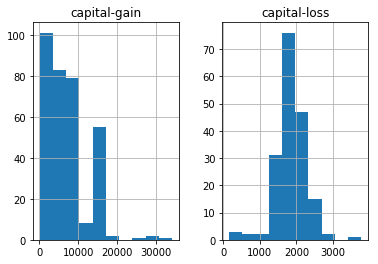

In [410]:
replaced = dataF[['capital-gain', 'capital-loss']].replace(to_replace=[0.0,99999.0],value = np.nan)
replaced.hist()

Pre tieto dva stlpce nebudeme odstranovat outlierov pretoze by sme prisli o tieto namerane hodnoty. 

In [411]:
detectReplaceOutliers(dataF)

kurtosis_oxygen q0.05: 0.9997197481277162
kurtosis_oxygen q0.95: 2.8793353976383194
skewness_glucose q0.05: 0.6798580937940952
skewness_glucose q0.95: 3.444043556136742
mean_glucose q0.05: 27.458593750000002
mean_glucose q0.95: 140.671875
std_oxygen q0.05: 2.6271018250534337
std_oxygen q0.95: 4.385862764886257
skewness_oxygen q0.05: 0.4882156079743155
skewness_oxygen q0.95: 5.633609736070209
kurtosis_glucose q0.05: 0.8360702216132279
kurtosis_glucose q0.95: 2.018652845557855
fnlwgt q0.05: 41468.600000000006
fnlwgt q0.95: 370317.3999999998
std_glucose q0.05: 31.172278147
std_glucose q0.95: 56.186057243
mean_oxygen q0.05: 1.2693000431742263
mean_oxygen q0.95: 4.702201274026498
hours-per-week q0.05: 17.0
hours-per-week q0.95: 60.0


C:\Users\adria\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [412]:
dataF.describe()

,age,kurtosis_oxygen,skewness_glucose,mean_glucose,std_oxygen,capital-gain,skewness_oxygen,kurtosis_glucose,fnlwgt,std_glucose,mean_oxygen,hours-per-week,capital-loss
count,3932.000000,3539.000000,3933.000000,3539.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3932.000000,3933.000000,3932.000000,3933.000000
mean,51.998474,2.161395,1.392046,101.391740,3.331006,1174.541571,3.703028,1.161344,185183.389016,45.046878,2.248832,40.398525,83.788457
std,11.780274,0.536881,0.800711,31.688818,0.570208,7963.624523,1.556380,0.338716,87777.119075,6.974492,1.053269,10.393927,393.300238
min,3.000000,0.999720,0.679858,27.458594,2.627102,0.000000,0.488216,0.836070,41468.600000,31.172278,1.269300,17.000000,0.000000
25%,45.000000,1.838181,0.867115,87.789062,2.864523,0.000000,2.732201,0.944740,118717.000000,40.164837,1.518466,40.000000,0.000000
50%,52.000000,2.337331,1.055645,110.539062,3.138429,0.000000,4.262546,1.033463,180599.000000,45.887636,1.746871,40.000000,0.000000
75%,60.000000,2.549694,1.522029,124.121094,3.822565,0.000000,4.863774,1.186856,235847.000000,50.369084,2.716764,45.000000,0.000000
max,113.000000,2.879335,3.444044,140.671875,4.385863,99999.000000,5.633610,2.018653,370317.400000,56.186057,4.702201,60.000000,3770.000000


Na stĺpce kde chýba málo hodnôt sme sa rozhodli použit nahradenie nulových hodnôt mediánom, kedže sa tam nachádza aj vek a počet odpracovaných hodín a priemer by bol desatíne číslo.

In [413]:
impMeanFit(dataF)
imp.statistics_

array([5.20000000e+01, 1.05564492e+00, 3.13842874e+00, 0.00000000e+00,
       4.26254570e+00, 1.03346334e+00, 1.80599000e+05, 4.58876364e+01,
       1.74687055e+00, 4.00000000e+01, 0.00000000e+00])

In [414]:
setKategNaNtoUnknown(dataF)

In [415]:
dataF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 26 columns):
age                 3933 non-null float64
sex                 3933 non-null object
date_of_birth       3933 non-null object
kurtosis_oxygen     3539 non-null float64
occupation          3933 non-null object
pregnant            3933 non-null object
education-num       3933 non-null object
skewness_glucose    3933 non-null float64
mean_glucose        3539 non-null float64
std_oxygen          3933 non-null float64
capital-gain        3933 non-null float64
skewness_oxygen     3933 non-null float64
kurtosis_glucose    3933 non-null float64
fnlwgt              3933 non-null float64
class               3933 non-null object
std_glucose         3933 non-null float64
income              3933 non-null object
mean_oxygen         3933 non-null float64
hours-per-week      3933 non-null float64
capital-loss        3933 non-null float64
workclass           3933 non-null object
ethn               

Z analýzy vieme, že nižšie vykreslené atribúty majú najbližšie k linearnemu grafu pre dané atribúty a preto ich použijeme pri lineárnej regresii.

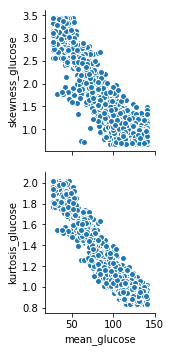

In [416]:
sns.pairplot(dataF,y_vars=["skewness_glucose", "kurtosis_glucose"], x_vars="mean_glucose")

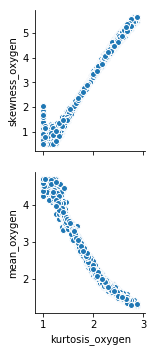

In [417]:
sns.pairplot(dataF,y_vars=["skewness_oxygen", "mean_oxygen"], x_vars=["kurtosis_oxygen"])

In [418]:
linearFit(dataF)

In [419]:
linearKurtOx.coef_

array([ 0.30577419, -0.05926713])

In [420]:
linearMeanGlu.coef_

array([  2.52847852, -95.37824563])

In [421]:
pred = linearKurtOx.predict(dataF[["skewness_oxygen","mean_oxygen"]])

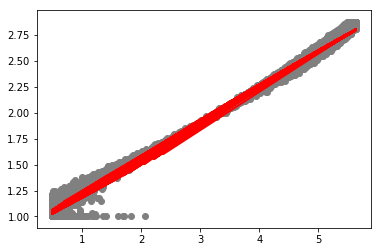

In [422]:
plt.scatter(dataF["skewness_oxygen"], dataF["kurtosis_oxygen"],  color='gray')
plt.plot(dataF["skewness_oxygen"], pred, color='red', linewidth=2)
plt.show()

In [423]:
predG = linearMeanGlu.predict(dataF[["skewness_glucose", "kurtosis_glucose"]])

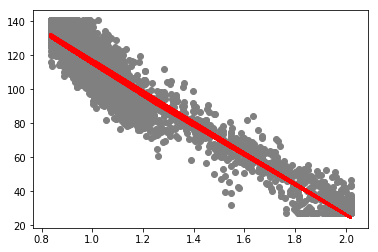

In [424]:
plt.scatter(dataF["kurtosis_glucose"], dataF["mean_glucose"],  color='gray')
plt.plot(dataF["kurtosis_glucose"], predG, color='red', linewidth=2)
plt.show()

In [425]:
linearTransform(dataF)

In [426]:
dataF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 26 columns):
age                 3933 non-null float64
sex                 3933 non-null object
date_of_birth       3933 non-null object
kurtosis_oxygen     3933 non-null float64
occupation          3933 non-null object
pregnant            3933 non-null object
education-num       3933 non-null object
skewness_glucose    3933 non-null float64
mean_glucose        3933 non-null float64
std_oxygen          3933 non-null float64
capital-gain        3933 non-null float64
skewness_oxygen     3933 non-null float64
kurtosis_glucose    3933 non-null float64
fnlwgt              3933 non-null float64
class               3933 non-null object
std_glucose         3933 non-null float64
income              3933 non-null object
mean_oxygen         3933 non-null float64
hours-per-week      3933 non-null float64
capital-loss        3933 non-null float64
workclass           3933 non-null object
ethn               

In [427]:
dataF.describe()

,age,kurtosis_oxygen,skewness_glucose,mean_glucose,std_oxygen,capital-gain,skewness_oxygen,kurtosis_glucose,fnlwgt,std_glucose,mean_oxygen,hours-per-week,capital-loss
count,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000
mean,51.998474,2.154328,1.392046,101.391746,3.331006,1174.541571,3.703028,1.161344,185183.389016,45.047091,2.248832,40.398424,83.788457
std,11.778776,0.539288,0.800711,31.570964,0.570208,7963.624523,1.556380,0.338716,87777.119075,6.973618,1.053269,10.392607,393.300238
min,3.000000,0.999720,0.679858,24.726394,2.627102,0.000000,0.488216,0.836070,41468.600000,31.172278,1.269300,17.000000,0.000000
25%,45.000000,1.818610,0.867115,88.359375,2.864523,0.000000,2.732201,0.944740,118717.000000,40.165726,1.518466,40.000000,0.000000
50%,52.000000,2.332338,1.055645,110.921875,3.138429,0.000000,4.262546,1.033463,180599.000000,45.887636,1.746871,40.000000,0.000000
75%,60.000000,2.546439,1.522029,123.640625,3.822565,0.000000,4.863774,1.186856,235847.000000,50.369068,2.716764,45.000000,0.000000
max,113.000000,2.879335,3.444044,140.671875,4.385863,99999.000000,5.633610,2.018653,370317.400000,56.186057,4.702201,60.000000,3770.000000


In [428]:
dataF.describe(exclude=np.number)

,sex,date_of_birth,occupation,pregnant,education-num,class,income,workclass,ethn,state,edu,status,fam_memb
count,3933,3933,3933,3933,3933,3933,3933,3933,3933,3933,3933,3933,3933
unique,2,3473,15,2,16,2,3,8,6,40,17,8,7
top,Male,1963-06-16,Prof-specialty,f,9.0,0.0,<=50K,Private,White,United-States,HS-grad,Married-civ-spouse,Husband
freq,2659,5,521,3865,1241,2929,2962,2705,3347,3511,1241,1813,1613


<h2>TEST</h2>

In [435]:
dataPer = pd.read_csv("personal_train.csv", index_col=0)
dataOth = pd.read_csv("other_train.csv", index_col=0)

In [436]:
dataFin = finalTransform(dataPer,dataOth)

correcting values


C:\Users\adria\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


working with outliers
kurtosis_oxygen q0.05: 0.9997197481277162
kurtosis_oxygen q0.95: 2.8793353976383194
skewness_glucose q0.05: 0.6798580937940952
skewness_glucose q0.95: 3.444043556136742
mean_glucose q0.05: 27.458593750000002
mean_glucose q0.95: 140.671875
std_oxygen q0.05: 2.6271018250534337
std_oxygen q0.95: 4.385862764886257
skewness_oxygen q0.05: 0.4882156079743155
skewness_oxygen q0.95: 5.633609736070209
kurtosis_glucose q0.05: 0.8360702216132279
kurtosis_glucose q0.95: 2.018652845557855
fnlwgt q0.05: 41468.600000000006
fnlwgt q0.95: 370317.3999999998
std_glucose q0.05: 31.172278147
std_glucose q0.95: 56.186057243
mean_oxygen q0.05: 1.2693000431742263
mean_oxygen q0.95: 4.702201274026498
hours-per-week q0.05: 17.0
hours-per-week q0.95: 60.0
filling missing values


C:\Users\adria\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [438]:
dataFin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 26 columns):
age                 3933 non-null float64
sex                 3933 non-null object
date_of_birth       3933 non-null object
kurtosis_oxygen     3933 non-null float64
occupation          3933 non-null object
pregnant            3933 non-null object
education-num       3933 non-null object
skewness_glucose    3933 non-null float64
mean_glucose        3933 non-null float64
std_oxygen          3933 non-null float64
capital-gain        3933 non-null float64
skewness_oxygen     3933 non-null float64
kurtosis_glucose    3933 non-null float64
fnlwgt              3933 non-null float64
class               3933 non-null object
std_glucose         3933 non-null float64
income              3933 non-null object
mean_oxygen         3933 non-null float64
hours-per-week      3933 non-null float64
capital-loss        3933 non-null float64
workclass           3933 non-null object
ethn               

In [439]:
dataFin.describe()

,age,kurtosis_oxygen,skewness_glucose,mean_glucose,std_oxygen,capital-gain,skewness_oxygen,kurtosis_glucose,fnlwgt,std_glucose,mean_oxygen,hours-per-week,capital-loss
count,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000,3933.000000
mean,51.998474,2.632394,1.392046,101.391746,3.331006,1174.541571,3.703028,1.161344,185183.389016,45.047091,2.248832,40.398424,83.788457
std,11.778776,2.105332,0.800711,31.570964,0.570208,7963.624523,1.556380,0.338716,87777.119075,6.973618,1.053269,10.392607,393.300238
min,3.000000,-3.342375,0.679858,24.726394,2.627102,0.000000,0.488216,0.836070,41468.600000,31.172278,1.269300,17.000000,0.000000
25%,45.000000,1.857415,0.867115,88.359375,2.864523,0.000000,2.732201,0.944740,118717.000000,40.165726,1.518466,40.000000,0.000000
50%,52.000000,2.361869,1.055645,110.921875,3.138429,0.000000,4.262546,1.033463,180599.000000,45.887636,1.746871,40.000000,0.000000
75%,60.000000,2.605583,1.522029,123.640625,3.822565,0.000000,4.863774,1.186856,235847.000000,50.369068,2.716764,45.000000,0.000000
max,113.000000,14.711773,3.444044,140.671875,4.385863,99999.000000,5.633610,2.018653,370317.400000,56.186057,4.702201,60.000000,3770.000000


<h2> Záver </h2>

Výsledkom predpracovania sú dve funkcie:<br>
    finalFitAndTransform(dataP,dataO), ktorá sa spúšťa nad trenovacími dátami, kde upraví hodnoty, zjednoti datasety, upraví outlierov a doplní chýbajúce hodnoty.<br>
    finalTransform(dataP,dataO), ktorá sa spúšťa po predchadzajúcej ale nad testovacými dátami.<br>
    Obydve funkcie vracajú predspracovaný dataset.